# Predicting Gold Recovered From Ore

In this project, a machine learning model will be created for Zyfra to predict the amount of gold recovered from gold ore using the data we were provided on the extraction and purification process. The datasets will first be viewed, cleaned, and checked for anomalies. Three different ML models will be compared using sMAPE (symmetric Mean Absolute Percentage Error) as the evaluation metric. The model with the lowest sMAPE will be validated against the test data.

## Load + Prepare Data

We are given three datasets. They will be defined as **df_full** (the source dataset), **df_train** (the training dataset), and **df_test** (the test dataset). The data will be observed and analyzed, and I will check to ensure that recovery (referencing the rougher.output.recovery feature) is calculated correctly. 

### Loading Datasets

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

In [2]:
# loading datasets 
try:
    df_full = pd.read_csv('/datasets/gold_recovery_full.csv')
    df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
    df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
except:
    print("One or more data files could not be read.")

### View Data

In [3]:
# view source data
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [4]:
# view training data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [5]:
# view test data
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

To summarize, **df_full** has 22716 entries and 87 columns. **df_train** has 16860 entries and 87 columns. **df_test** has 5856 entries and 53 columns. The test set is missing many features; this is expected. Features that were calculated later, as well as targets, are excluded from the test dataset.

All three datasets have null values across multiple columns.

### Check Recovery
Within the training set, we need to check that `rougher.output.recovery` was calculated correctly.

The formula to simulate the recovery process is as follows: `[C x (F - T)]/[F x (C - T)] * 100`
Where C = share of gold in the concentrate right after flotation, F = share of gold in the feed before flotation, and T = share of gold in the rougher tails right after flotation.

* C = `rougher.output.concentrate_au`
* F = `rougher.input.feed_au`
* T = `rougher.output.tail_au`

In [6]:
# given gold in concentration after flotation, gold in feed before flotation, and gold in rougher
# tails after flotation, calculate the percentage that was recovered
def calculate_recovery(C, F, T):
    numerator = C * (F - T)
    denominator = F * (C - T)
    return numerator / denominator * 100

In [7]:
# features required in the formula
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

# create new column based on C, F, T
predicted_recovery = calculate_recovery(C, F, T)

In [8]:
# check that predicted was calculated
predicted_recovery

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Length: 16860, dtype: float64

In [9]:
def calculate_mae(target, predicted): 
    return (predicted - target).abs().mean()

In [10]:
# calculate MAE 
target_recovery = df_train['rougher.output.recovery']

calculate_mae(predicted_recovery, target_recovery)

9.303415616264301e-15

The MAE is extremely close to 0. This indicates that recovery was calculated correctly.

### Test Set
As stated above, the test set is missing numerous features due to when the data for it was pulled. I will be analyzing the features that are missing from it.

In [11]:
# creating set of test and train columns
df_test_columns = set(df_test.columns)
df_train_columns = set(df_train.columns)

# show columns missing from df_test
missing_test_columns = df_train_columns - df_test_columns
print(f'The test dataset is missing {len(missing_test_columns)} features.')
missing_test_columns

The test dataset is missing 34 features.


{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [12]:
# view types of missing features
def get_feature_type(df, columns):
    for column in columns:
        print(f'{column}: {df[column].dtype}')

get_feature_type(df_train, missing_test_columns)

final.output.tail_pb: float64
rougher.calculation.floatbank10_sulfate_to_au_feed: float64
rougher.calculation.au_pb_ratio: float64
rougher.calculation.sulfate_to_au_concentrate: float64
rougher.output.concentrate_sol: float64
primary_cleaner.output.concentrate_pb: float64
rougher.output.tail_sol: float64
secondary_cleaner.output.tail_ag: float64
final.output.tail_au: float64
rougher.output.concentrate_au: float64
primary_cleaner.output.concentrate_au: float64
rougher.output.recovery: float64
final.output.concentrate_au: float64
rougher.output.concentrate_ag: float64
primary_cleaner.output.concentrate_sol: float64
primary_cleaner.output.tail_sol: float64
primary_cleaner.output.concentrate_ag: float64
rougher.output.tail_pb: float64
final.output.concentrate_sol: float64
final.output.tail_ag: float64
final.output.concentrate_pb: float64
secondary_cleaner.output.tail_au: float64
secondary_cleaner.output.tail_pb: float64
final.output.tail_sol: float64
rougher.output.concentrate_pb: float64


All of the missing columns from the test dataset are floats.

### Data Preprocessing

#### Converting Data Types
Every column is a float type except the data column, which is currently an object type. I will be converting this to a datetime type.

In [13]:
# convert object to date
df_test['date'] = pd.to_datetime(df_test['date'])
df_train['date'] = pd.to_datetime(df_train['date'])
df_full['date'] = pd.to_datetime(df_full['date'])

In [14]:
# check conversion
df_test['date']

0      2016-09-01 00:59:59
1      2016-09-01 01:59:59
2      2016-09-01 02:59:59
3      2016-09-01 03:59:59
4      2016-09-01 04:59:59
               ...        
5851   2017-12-31 19:59:59
5852   2017-12-31 20:59:59
5853   2017-12-31 21:59:59
5854   2017-12-31 22:59:59
5855   2017-12-31 23:59:59
Name: date, Length: 5856, dtype: datetime64[ns]

The date columns have been converted to datetime types.

#### Filling Null Values
We want to address null values in each of the datasets. There are many null values across numerous columns, so I will see which columns in each dataset have the highest percentage of nulls.

In [15]:
def show_max_null_percentages(df):
    null_df = (df.isnull().sum() / len(df)).sort_values(ascending=False).head(5)
    print(null_df)

In [16]:
# show highest null percentages for source dataset
show_max_null_percentages(df_full)

rougher.output.recovery               0.137304
rougher.output.tail_ag                0.120488
rougher.output.tail_au                0.120444
rougher.output.tail_sol               0.120444
rougher.input.floatbank11_xanthate    0.099357
dtype: float64


In [17]:
# view value counts
df_full['rougher.output.recovery'].value_counts(dropna=False)

NaN           3119
0.000000       419
83.406924       10
89.512544        6
100.000000       6
              ... 
84.304578        1
81.281279        1
87.035862        1
81.017150        1
82.366128        1
Name: rougher.output.recovery, Length: 19150, dtype: int64

In [18]:
# show highest null percentages for training dataset
show_max_null_percentages(df_train)

rougher.output.recovery              0.152610
rougher.output.tail_ag               0.133452
rougher.output.tail_sol              0.133393
rougher.output.tail_au               0.133393
secondary_cleaner.output.tail_sol    0.117794
dtype: float64


In [19]:
# show highest null percentages for test dataset
show_max_null_percentages(df_test)

rougher.input.floatbank11_xanthate    0.060280
primary_cleaner.input.sulfate         0.051571
primary_cleaner.input.depressant      0.048497
rougher.input.floatbank10_sulfate     0.043887
primary_cleaner.input.xanthate        0.028347
dtype: float64


For the test_dataset, all NA values are about 6% or lower. The source dataset and training dataset both are missing up to 15% of their data in select columns. We are, however, told that parameters next to each other in terms of time are often similar since each row is based on a unique time. Because of this, it would be more appropriate to fill the missing data with information from previous rows instead of dropping these rows or using the average.

In [20]:
# convert 0s to nulls
df_train = df_train.replace(0, np.nan)
df_test = df_test.replace(0, np.nan)
df_full = df_full.replace(0, np.nan)

# fill null values
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')
df_full = df_full.fillna(method='ffill')

In [21]:
# check that nulls have been replaced
show_max_null_percentages(df_full)

date                                 0.0
rougher.state.floatbank10_b_air      0.0
rougher.state.floatbank10_f_air      0.0
rougher.state.floatbank10_e_level    0.0
rougher.state.floatbank10_e_air      0.0
dtype: float64


In [22]:
# view value counts
df_full['rougher.output.recovery'].value_counts(dropna=False)

75.040308    219
89.665085    163
68.920897    159
80.282056    156
89.524162    132
            ... 
89.429411      1
68.712376      1
77.462730      1
91.433028      1
82.366128      1
Name: rougher.output.recovery, Length: 19148, dtype: int64

NaN and invalid values have been replaced.

So far, the data files have been opened and observed. In the training set, I confirmed that `rougher.output.recovery` had been calculated correctly by finding the mean absolute error. The 34 features not in the test dataset have been discussed, and the data was preprocessed by filling in missing values.

## Analyze Data

### Changes in Concentration
First, I will observe how the quantities of silver, gold, and lead change depending on the stage in the purification process.

In [23]:
# gold, silver, and lead
metals = ['au', 'ag', 'sol'] 

# stages with concentrate output
stages = ['rougher', 'primary_cleaner', 'final']

In [24]:
# for each metal and stage, print the average concentration
for metal in metals:
    print(metal)
    for stage in stages:
        stage_output = f'{stage}.output.concentrate_{metal}'
        print(stage, ':', df_train[stage_output].mean())
    print('')

au
rougher : 18.188257351188454
primary_cleaner : 30.472709913894644
final : 41.13267951940478

ag
rougher : 11.056623565811702
primary_cleaner : 7.668386657233557
final : 4.988969168253581

sol
rougher : 26.435106922812967
primary_cleaner : 9.574777246029143
final : 8.577699690861175



It seems that for gold (au), the amount of gold increases as we progress through the purification process. The opposite is true for silver (ag) and lead (sol): The amount of each of these metals decrease as the purification process continutes.

### Feed Particles in Training + Test Sets
Next, I will compare the feed particle size distribution between the training set and the test set. If they are significantly different, it indicates that the model evaluation will be incorrect. 

There are two `feed_size` columns that the training and test set share: `primary_cleaner.input.feed_size` and `rougher.input.feed_size`.

In [25]:
# get primary cleaner means
test_primary_feedsize = df_test['primary_cleaner.input.feed_size'].mean()
train_primary_feedsize = df_train['primary_cleaner.input.feed_size'].mean()

# get rougher means
test_rougher_feedsize = df_test['rougher.input.feed_size'].mean()
train_rougher_feedsize = df_train['rougher.input.feed_size'].mean()

In [26]:
print('Primary Cleaner Input Feed Sizes')
print(f'TEST - {test_primary_feedsize}')
print(f'TRAIN - {train_primary_feedsize}')

print('\nRougher Input Feed Sizes')
print(f'TEST - {test_rougher_feedsize}')
print(f'TRAIN - {train_rougher_feedsize}')

Primary Cleaner Input Feed Sizes
TEST - 7.2646512922454205
TRAIN - 7.297284871257225

Rougher Input Feed Sizes
TEST - 55.89886568885065
TRAIN - 60.18859533601633


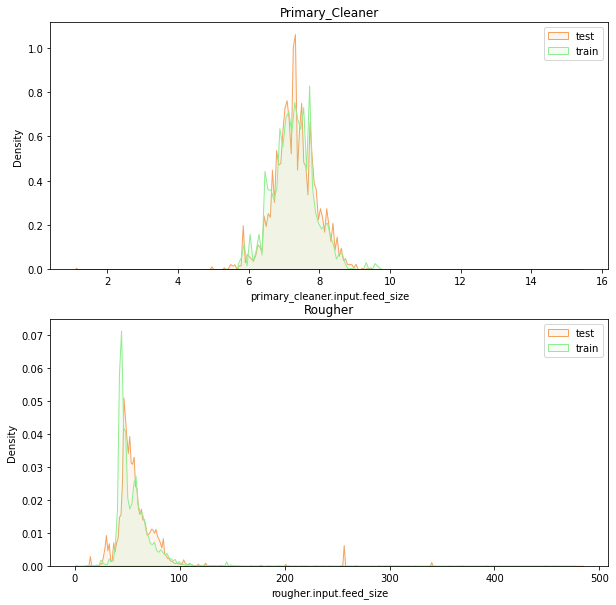

In [27]:
# create subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
colors = ['sandybrown', 'lightgreen']
stages = ['primary_cleaner', 'rougher']
datasets = ['test', 'train']

for i, stage in enumerate(stages):
    for j, df in enumerate([df_train, df_test]):
        col = f'{stage}.input.feed_size'
        sns.histplot(data=df[col], ax = ax[i], alpha = 0.1, element = 'poly', color = colors[j],
                    label = datasets[j], stat = 'density')
    ax[i].legend()
    ax[i].set_title(f'{stage.title()}')

Above, I have looked at the means of the test and training data set across the primary_cleaner and roughter stages as well as looked at the distribution. They are similar.

### Total Concentrations

In [28]:
for col in df_train.columns:
    if "output.concentrate" in col:
        print(col)

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au


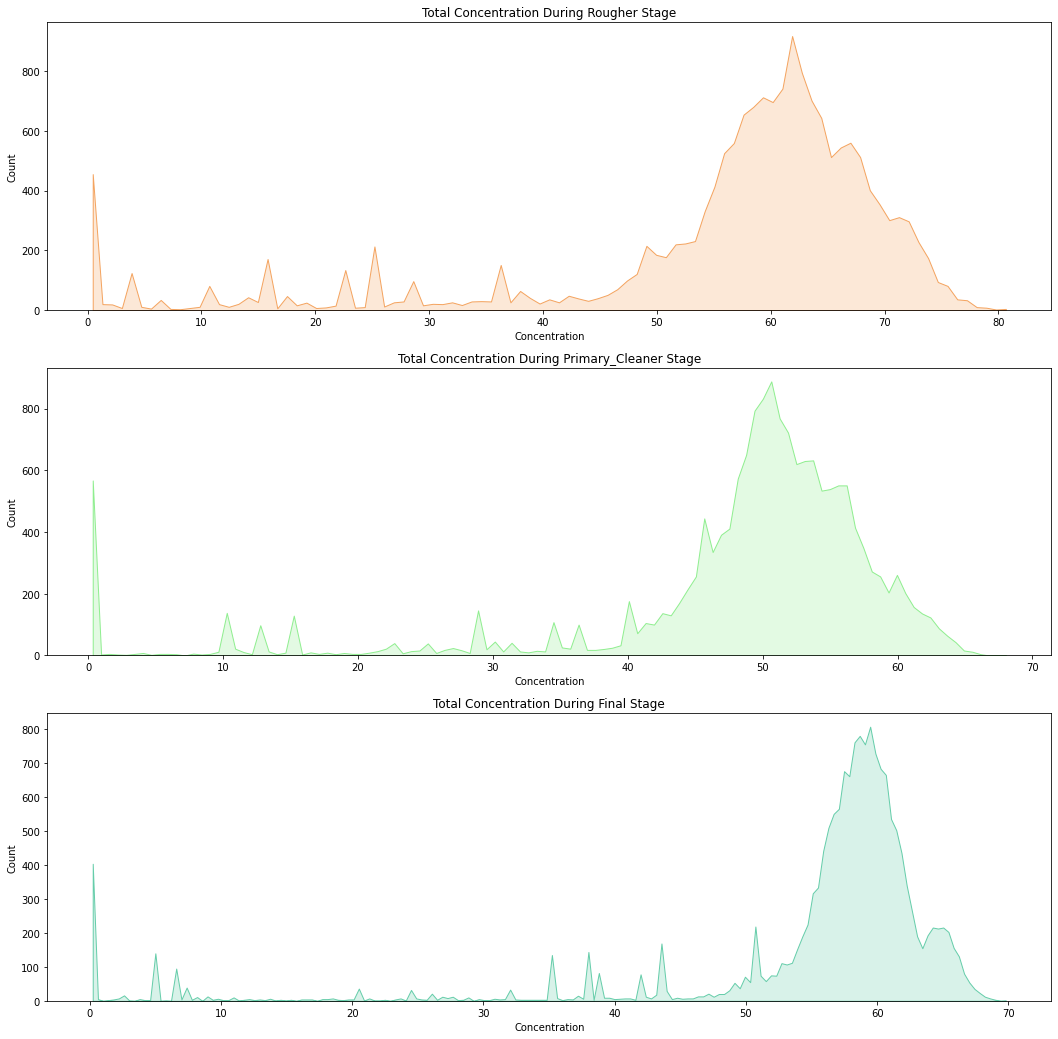

In [29]:
# create subplots
fig, ax = plt.subplots(3, 1, figsize=(18, 18))

metal_full = ['Gold', 'Silver', 'Lead']
colors = ['sandybrown', 'lightgreen', 'mediumaquamarine'] 
stages = ['rougher', 'primary_cleaner', 'final']

# plot one graph per stage
for i, stage in enumerate(stages):
    
    ax[i].set_title(f'Total Concentration During {stage.title()} Stage')
    ax[i].set_xlabel(f'Concentration')
    
    # create columns in train and test
    new_col = f'{stage}.output.total_concentrate'
    df_train[new_col] = df_train[f'{stage}.output.concentrate_{metals[0]}'] + df_train[f'{stage}.output.concentrate_{metals[1]}'] + df_train[f'{stage}.output.concentrate_{metals[2]}']
    df_full[new_col] = df_full[f'{stage}.output.concentrate_{metals[0]}'] + df_full[f'{stage}.output.concentrate_{metals[1]}'] + df_full[f'{stage}.output.concentrate_{metals[2]}']
    
    sns.histplot(
            data = df_train[new_col], ax = ax[i], alpha = 0.25, 
            element = 'poly', color = colors[i], label = stage
        )

Each metal has a high count of values close to 0. I want to see if these are abnormal.

In [30]:
# view a few instances of low value concentrations
df_train[df_train['primary_cleaner.output.total_concentrate'] < 0.05][['primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_sol']].head()

,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_sol
12498,0.01,0.01,0.01
12499,0.01,0.01,0.01
12500,0.01,0.01,0.01
12568,0.01,0.01,0.01
12569,0.01,0.01,0.01


In [31]:
# check surrounding values
df_train.iloc[12495:12505][['primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_sol']]

,primary_cleaner.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_sol
12495,31.203121,10.576060,15.044411
12496,30.021952,11.078088,14.402412
12497,1.961528,0.714743,0.859003
12498,0.010000,0.010000,0.010000
12499,0.010000,0.010000,0.010000
12500,0.010000,0.010000,0.010000
12501,7.641986,1.353747,0.010000
12502,32.047841,10.005311,12.638254
12503,31.512322,10.226795,12.698867
12504,31.137925,10.260248,12.204605


Rows close to each other should be similar in value. There's a massive drop off in concentration across all rows - this is likely abnormal, so it would be beneficial to remove these abnormal values in the event that future analyses are sensitive to values close to zero.

In [32]:
# storing original dataset sizes
original_train_size = len(df_train)
original_full_size = len(df_full)

In [33]:
# dropping anomalies
df_train = df_train[df_train['primary_cleaner.output.total_concentrate'] > 0.05]
df_train = df_train[df_train['rougher.output.total_concentrate'] > 0.05]

df_full = df_full[df_full['primary_cleaner.output.total_concentrate'] > 0.05]
df_full = df_full[df_full['rougher.output.total_concentrate'] > 0.05]

In [34]:
print(f'{100 - (len(df_train) / original_train_size * 100):.3}% of the training data was dropped.')
print(f'{100 - (len(df_full) / original_full_size * 100):.3}% of the full data was dropped.')

3.71% of the training data was dropped.
2.75% of the full data was dropped.


In [35]:
# drop created columns
df_full = df_full.drop(['rougher.output.total_concentrate', 'primary_cleaner.output.total_concentrate', 'final.output.total_concentrate'], axis=1)
df_train = df_train.drop(['rougher.output.total_concentrate', 'primary_cleaner.output.total_concentrate', 'final.output.total_concentrate'], axis=1)

The anamolies have been removed.

Now that the data has been analyzed and cleaned, the models can be built.

## Build Models

### Calculate sMAPE

In [36]:
# function to calculate the final sMAPE 
def calculate_final_smape(smape_rougher, smape_final):
    return (0.25 * smape_rougher) + (0.75 * smape_final)

In [37]:
def calculate_smape(y, y_pred):
    return np.sum(abs(y - y_pred) / ((abs(y) + abs(y_pred)) / 2) * 100) / len(y)

In [38]:
# create smape scorer to be used as the cross-val metric
smape_score = make_scorer(calculate_smape)

### Prepare Data
Before training the model, I will drop the `date` column since it is a unique identifier. I will also need to drop all columns from the training dataset that are not in the test dataset - the number of columns needs to be the same between the training and test datasets or the model will run into an error.

In [39]:
# obtaining recovery information from full dataset to test dataset
df_test = df_test.merge(df_full[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date', how='left')

In [40]:
# drop date columns
df_train = df_train.drop(['date'], axis=1)
df_test = df_test.drop(['date'], axis=1)

In [41]:
# declaring constants
ROUGHER_OUTPUT_RECOVERY = 'rougher.output.recovery'
FINAL_OUTPUT_RECOVERY = 'final.output.recovery'
DROP_COLS = [ROUGHER_OUTPUT_RECOVERY, FINAL_OUTPUT_RECOVERY]

In [42]:
# drop extra columns not in the test dataset
missing_test_columns.remove(ROUGHER_OUTPUT_RECOVERY)
missing_test_columns.remove(FINAL_OUTPUT_RECOVERY)
df_train = df_train.drop(missing_test_columns, axis=1)

In [43]:
# method to get features and target of each dataset
def get_features_and_target(target_col, drop_cols, data):
    features = data.drop(drop_cols, axis = 1)
    target = data[target_col]
    
    return features, target

In [44]:
def get_best_score(features, target):
    best_score = 0
    best_model = None
    models = [LinearRegression(), DecisionTreeRegressor(random_state=12345), RandomForestRegressor(random_state=12345)]
    scores = []
    
    for model in models:
        score = cross_val_score(model, features, target, scoring=smape_score).mean()
        scores.append(score)
        print(f'Score: {score:.3} - Model: {model}')
    
    return scores

### Checking Models

Three models (Linear Regression, Decision Tree, Random Forest) will be applied to the training data for both the rougher recovery output and the final recovery output. These models will be evaluated using cross-validation. The best model will be chosen.

Because we are using cross-validation as our metric, the datasets do not need to be split into validation sets, nor do the models need to be trained ahead of time.

#### Rougher Output Recovery

In [45]:
# splitting training/testing sets into features and targets
features_train_rougher, target_train_rougher = get_features_and_target(ROUGHER_OUTPUT_RECOVERY, DROP_COLS, df_train)
features_test_rougher, target_test_rougher = get_features_and_target(ROUGHER_OUTPUT_RECOVERY, DROP_COLS, df_test)

In [46]:
# check the cross validation score of three models and print results
rougher_scores = get_best_score(features_train_rougher, target_train_rougher)

Score: 10.5 - Model: LinearRegression()
Score: 12.0 - Model: DecisionTreeRegressor(random_state=12345)
Score: 8.85 - Model: RandomForestRegressor(random_state=12345)


The Random Forest model has the best smape for rougher output recovery.

#### Final Output Recovery

In [47]:
# splitting training/testing sets into features and targets
features_train_final, target_train_final = get_features_and_target(FINAL_OUTPUT_RECOVERY, DROP_COLS, df_train)
features_test_final, target_test_final = get_features_and_target(FINAL_OUTPUT_RECOVERY, DROP_COLS, df_test)

In [48]:
# check the cross validation score of three models and print results
final_scores = get_best_score(features_train_final, target_train_final)

Score: 12.1 - Model: LinearRegression()
Score: 20.3 - Model: DecisionTreeRegressor(random_state=12345)
Score: 11.6 - Model: RandomForestRegressor(random_state=12345)


The Random Forest model has the best smape for final output recovery.

#### Final sMAPE
Now that the scores for the rougher recovery and final output recovery have been calculated, I will determine the model with the best final sMAPE score.

In [49]:
models = [LinearRegression(), DecisionTreeRegressor(random_state=12345), RandomForestRegressor(random_state=12345)]
for i in range(len(models)):
    final_smape = calculate_final_smape(rougher_scores[i], final_scores[i])
    print(f'sMAPE: {final_smape:.3} - Model: {models[i]}')

sMAPE: 11.7 - Model: LinearRegression()
sMAPE: 18.3 - Model: DecisionTreeRegressor(random_state=12345)
sMAPE: 10.9 - Model: RandomForestRegressor(random_state=12345)


The weighted sMAPE score is also best for the Random Forest model, which has a final score of 4.79. So, the random forest model will be used for the test data.

### Testing Random Forest

In [50]:
# create one model for the rougher output and one for the final output
model_rougher = RandomForestRegressor(random_state=12345)
model_final = RandomForestRegressor(random_state=12345)

# fit models to training data
model_rougher.fit(features_train_rougher, target_train_rougher)
model_final.fit(features_train_final, target_train_final)

# predict
rougher_predictions = model_rougher.predict(features_test_rougher)
final_predictions = model_final.predict(features_test_final)

In [51]:
# get smape
rougher_smape = calculate_smape(target_test_rougher, rougher_predictions)
final_smape = calculate_smape(target_test_final, final_predictions)

# calculate overall smape
overall_smape = calculate_final_smape(rougher_smape, final_smape)

In [52]:
overall_smape

9.860216698945695

The overall sMAPE score for the Random Forest Model is 9.86. 